In [9]:
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import cv2
from glob import glob
from sklearn.decomposition import PCA
from pytorch_lightning import LightningDataModule

import matplotlib.pyplot as plt

In [3]:
path_cubes = 'E:/90_data/PX_Compost/processed/'

In [92]:
class HyperspectralDataset(Dataset):
    def __init__(self, cube_dir, mask_dir, window_size, stride):
        self.cube_dir = cube_dir
        self.mask_dir = mask_dir
        self.window_size = window_size
        self.stride = stride
        self.p = window_size // 2
        # list subfolders starting with E
        self.cube_files = [i.split('\\')[-1] for i in glob(os.path.join(cube_dir, 'E*'))]
        self.current_cube = None
        self.current_mask = None
        self.current_cube_index = -1
        self.image_shape = None
        self.n_pc = 15
        self.window_indices = self.prepare_window_indices()
        self.gradient_mask = self.get_gradient_mask()


    def prepare_window_indices(self):
        window_indices = []
        for cube_index, cube_file in enumerate(self.cube_files):
            cube_path = os.path.join(self.cube_dir, cube_file, 'hsi.npy')
            cube = np.load(cube_path)
            #cube = np.transpose(cube, (1, 0, 2))
            self.image_shape = cube.shape[:2]

            for i in range(cube.shape[0] // self.stride):
                for j in range(cube.shape[1] // self.stride):
                    window_indices.append((cube_index, i * self.stride, j * self.stride))
        return window_indices

    def load_cube(self, cube_index):
        if cube_index != self.current_cube_index:
            cube_path = os.path.join(self.cube_dir, self.cube_files[cube_index])

            mask_all = cv2.imread(os.path.join(cube_path, 'mask.bmp'), cv2.IMREAD_GRAYSCALE)
            
            """ # loading of masks when experiments are annotated in the old fashioned way (i.e. one mask per object)
            mask_all = np.zeros(self.image_shape)
            hsi_masks = glob(os.path.join(self.mask_dir, self.cube_files[cube_index], 'hsi_masks/*bmp'))
            # TODO: if more classes are introduced mask needs to be int and not bool
            for mask_file in hsi_masks:
                # load image with PIL
                mask = Image.open(mask_file)
                mask = np.array(mask)
                mask = cv2.resize(mask, (self.image_shape[1], self.image_shape[0]))
                mask_all = np.logical_or(mask_all, mask)"""

            self.current_cube = np.load(os.path.join(cube_path, 'hsi.npy'))
            self.pre_process_cube()
            self.current_cube = np.pad(self.current_cube, ((self.p, self.p), (self.p, self.p), (0, 0)), mode='constant', constant_values=0)

            self.current_mask = mask_all
            self.current_mask = np.pad(self.current_mask, ((self.p, self.p), (self.p, self.p)), mode='constant', constant_values=0)
            self.current_mask = self.current_mask.astype(int)
            self.current_cube_index = cube_index

        else:
            pass

    def pre_process_cube(self):
        # TODO: implement pca, random occlusion, gradient masking (if necessary)
        self.crop_bands()
        self.remove_background()
        self.apply_pca()
        pass

    def apply_pca(self):
        """Applies PCA to cube and reduces number of bands to 15.
        
        Note: 
            - Function assumes that edge bands are removed, i.e. spectra are cropped. 
        """

        x = self.current_cube.reshape(-1, self.current_cube.shape[-1])
        x = x.astype(float)

        # TODO: check for optimal number of components
        pca = PCA(n_components=self.n_pc)
        x = pca.fit_transform(x)
        x = x.reshape(self.current_cube.shape[0], self.current_cube.shape[1], 15)

        self.current_cube = x

    def remove_background(self):
        """Sets spectra with mean intensity below 600 to zero on all bands. Treats overall low intensity spectra as background. 
        
        Note: 
            - Changes in light intensity between cubes are not considered.
            - Function assumes that edge bands are removed, i.e. spectra are cropped. 
        """
        mean_intensity = np.mean(self.current_cube, axis=2)
        self.current_cube[mean_intensity < 600] = 0

    def crop_bands(self):
        """Removes bands 0-8 and 210-224. Assumes cube is of shape (w, h, 224).
        
        Note: 
            - Function assumes that edge bands are removed, i.e. spectra are cropped. 
        """
        self.current_cube = self.current_cube[:, :, 8:210]


    def apply_gradient_mask(self, window):
        """Applies gradient mask to window as described in https://www.mdpi.com/2072-4292/15/12/3123"""
        return window * self.gradient_mask

    def get_gradient_mask(self):
        s = self.window_size
        p = self.n_pc
        center = (s + 1) / 2
        mask = np.zeros((s, s))
        for i in range(s):
            for j in range(s):
                mask[i, j] = 1 - ((i - center + 1)**2 + (j - center + 1)**2) / (2 * center**2)

        mask = np.expand_dims(mask, axis=0)
        mask = np.repeat(mask, p, axis=0)

        return mask


    def __len__(self):
        return len(self.window_indices)

    def __getitem__(self, idx):
        cube_index, i, j = self.window_indices[idx]
        self.load_cube(cube_index)
        window = self.current_cube[i:i+self.window_size, j:j+self.window_size, :].astype(np.float32)
        window = np.transpose(window, (2, 0, 1))
        window_mask = self.current_mask[i:i+self.window_size, j:j+self.window_size]

        window = self.apply_gradient_mask(window)
        return window, window_mask


class HyperspectralDataModule(LightningDataModule):
    def __init__(self, cube_dir, mask_dir, window_size, stride, batch_size):
        super().__init__()
        self.cube_dir = cube_dir
        self.mask_dir = mask_dir
        self.window_size = window_size
        self.stride = stride
        self.batch_size = batch_size

    def train_dataloader(self):
        train_dataset = HyperspectralDataset(self.cube_dir, self.mask_dir, self.window_size, self.stride)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        test_dataset = HyperspectralDataset(self.cube_dir, self.mask_dir, self.window_size, self.stride)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

In [93]:
batch_size = 1
window_size = 256
stride = 1
data_module = HyperspectralDataModule(path_cubes, path_cubes, window_size, stride, batch_size)
train_loader = data_module.train_dataloader()

In [94]:
len(train_loader.dataset)

37144634

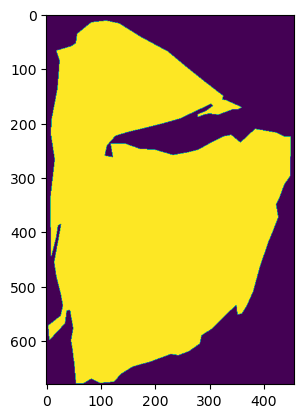

In [97]:
window, mask = train_loader.dataset[37144633]

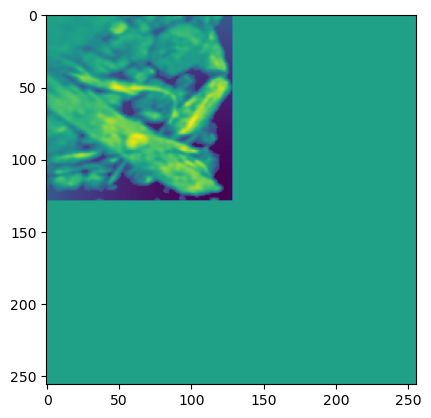

In [98]:
plt.imshow(window.transpose(1, 2, 0)[:, :, 0])

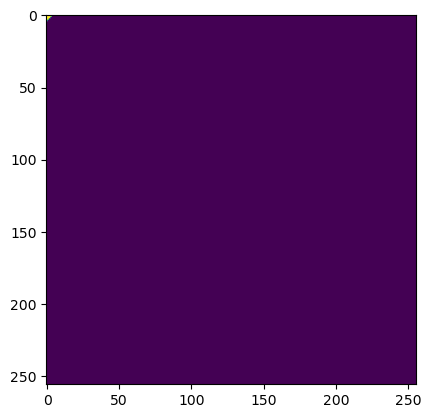

In [99]:
plt.imshow(mask)